In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from numba import jit
from numpy import zeros, arange, uint8, int32, float32, sqrt, uint32, ones, vstack, concatenate
from numpy import int64, mean, ceil, where, log2, max, min, median, var, log, array, sum
from numpy.random import randn, uniform
from numpy.fft import fft, ifft, fftfreq
from sbi import utils as utils
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import numpy as np
import torch
import os
import _pickle as pickle
from scipy.optimize import curve_fit
from scipy.stats import zscore

In [2]:
def corr(x,y,nmax,dt=False):
    '''
    Performs the cross correlation between two single-input signals x and y.

    INPUT
    x: input signal 1
    y: input signal 2
    nmax: maximum number of lags
    dt: time step (default=False)

    OUTPUT
    corr: cross-correlation between x and y
    '''

    assert len(x)==len(y), 'x and y must have the same length'

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**ceil(log2(ext_size)).astype('int')

    xp=x-mean(x)
    yp=y-mean(y)

    # do fft and ifft
    cfx=fft(xp,fsize)
    cfy=fft(yp,fsize)
    if dt != False:
        freq = fftfreq(n, d=dt)
        idx = where((freq<-1/(2*dt))+(freq>1/(2*dt)))[0]
        
        cfx[idx]=0
        cfy[idx]=0
        
    sf=cfx.conjugate()*cfy
    corr=ifft(sf).real
    corr=corr/n

    return corr[:nmax]

def stat_corr_single(single_x_trace, DeltaT, t, t_corr):
    '''
    Computes the autocorrelation for a single x trace signal.

    INPUT
    singles_x_trace: single x trace signal
    DeltaT: sampling time
    t: time array
    t_corr: maximum time for the correlation

    OUTPUT
    Cxx: autocorrelation x signal
    '''

    sampled_point_amount = single_x_trace.shape[0]
    idx_corr = np.where((t>0)*(t<t_corr))[0]
    Cxx= corr(single_x_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace

    return Cxx

def stat_s_redx(Cxx, t_corr, t, mu_x=1, k_x=1, kbT=1):
    '''
    Computes the reduced energy production for a single x trace signal.

    INPUT
    Cxx: autocorrelation signal
    t_corr: maximum time for the correlation
    t: time array
    theta_i: parameters

    OUTPUT
    S_red: reduced x energy production
    '''
    D_x = kbT * mu_x
    
    S1 = cumulative_trapezoid(Cxx, x=t, axis=-1, initial=0)
    S1 = cumulative_trapezoid(S1, x=t, axis=-1, initial=0)
    #idx_corr = where((t>0)*(t<t_corr))[0]
    S_red1 = (Cxx[0]-Cxx)/(D_x*t) # First term in S_red
    S_red2 = ((mu_x*k_x)**2)*S1/(D_x*t) # Second term in S_red
    S_red = S_red1 + S_red2 # Compute S_red

    return S_red1, S_red2, S_red

In [3]:
@jit
def SimulateArmonicOscillator(dt, TotalT, param):
    k = param[0]
    D = param[1]
    time_steps_amount = np.int64(TotalT/dt)

    x = 0
    x_tilde = 0
    x_trace = np.zeros((1, time_steps_amount))
    
    for t in np.arange(0, time_steps_amount):
        
        x_tilde = x + -k * x * dt + np.sqrt(2*D) * np.random.normal(0, np.sqrt(dt))
        x = x_tilde + (+k * x - k*x_tilde)*dt /2
        x_trace[0,t] = x
    
    return x_trace
    

In [19]:
dt = 1e-3
TotalT = 1000
param = [2., 1.]
t = np.arange(0, TotalT, dt)

x_trace = SimulateArmonicOscillator(dt, TotalT, param)
print("Mean x squared: ", np.mean(x_trace**2))

Mean x squared:  0.49418881736985276


In [20]:
cxx = stat_corr_single(x_trace[0], dt, t, 1)

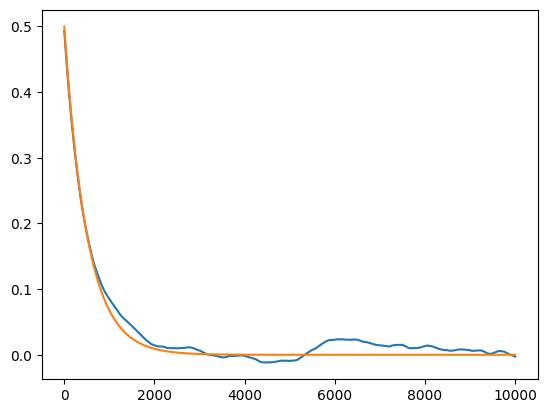

In [23]:
plt.plot(cxx[:10000])
plt.plot(np.exp(-t*2)[:10000]/2)